In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance
from scipy.sparse.csgraph import minimum_spanning_tree
import math
import time

import pickle

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## USING PREVIOUS DATA

We want to be able to save thing 

IF PICKLED = True then we will previously simulated data using the pickle packge

In [2]:
PICKLED = True

### Simulation stage

In [3]:
from modules.dp_bounds_threaded import dp_bounds
# from modules.dp_bounds import dp_bounds

from modules.Bhattacharyya_bounds import Bhattacharyya_bounds



In [4]:
sample_sizes = np.logspace(2, 3.3011, 8 , endpoint = True, dtype = int)

sample_sizes

array([ 100,  153,  235,  361,  553,  849, 1303, 2000])

In [5]:
mean_sep = 2.56
# Set the mean and covariance matrix for each Gaussian distribution

mean1 = [0, 0, 0 , 0 , 0, 0, 0 , 0]
# covariance1 = np.ones((3,3))
covariance1 = np.identity(8)
# covariance1 = [[1, 0, 0],  [0, 1, 0], [0, 0, 0]

mean2 = [mean_sep, 0, 0 , 0, 0, 0,0, 0 ]
# mean2 = [math.sqrt(1/2), math.sqrt(1/2), 0]

# covariance2 = np.ones((3,3))
covariance2= np.identity(8)


MC_num = 400


##### Run the simulation

In [6]:

dp_lst = []

Bha_lst = []

if PICKLED: ## We just skip all the data creation if we are using save data. 
    print("USING PREVIOUS DATA NOT SIMULATING DATA ")
else:
    for i in sample_sizes:

        start = time.time()

        n0, n1 = i, i
        params1  = [mean1, covariance1, n0]
        params2  = [mean2, covariance2, n1]

        dp_class = dp_bounds('mv_normal', params1, params2, MC_num, threads = 4, handle_errors= 'worst')
    #     dp_class = dp_bounds('mv_normal', params1, params2, MC_num, handle_errors= 'worst')

        Bha_class = Bhattacharyya_bounds('mv_normal', params1, params2, MC_num)

        dp_lst.append(dp_class)
        Bha_lst.append(Bha_class)
        end = time.time()
        print("done with ", i, " in ",  end -start )


USING PREVIOUS DATA NOT SIMULATING DATA 


##### Pickling
This is where the data either gets save or loaded

In [7]:
file_path = 'sim_data/mse_data_v1.pkl'


if PICKLED  == False:
    objects_to_save = [dp_lst, Bha_lst]


    with open(file_path, 'wb') as file:
        # Use pickle.dump to serialize and write the list of objects to the file
        pickle.dump(objects_to_save, file)
    print(f'Objects saved to {file_path}')
    

elif PICKLED == True:
    

    # Open the file in binary read mode
    with open(file_path, 'rb') as file:
        # Use pickle.load to deserialize and load the list of objects from the file
        loaded_objects = pickle.load(file)

    print('Loaded object successfully')
    
    dp_lst, Bha_lst = loaded_objects

Loaded object successfully


In [20]:
dp_lst[0].get_bounds_stats()

[DescribeResult(nobs=400, minmax=(0.047230743093129135, 0.16833752096446003), mean=0.10309521665764337, variance=0.00044896537339042704, skewness=0.3343899964823417, kurtosis=-0.026772342479954858),
 DescribeResult(nobs=400, minmax=(0.08999999999999997, 0.28), mean=0.18403750000000002, variance=0.001113043703007518, skewness=0.18577625983899348, kurtosis=-0.16824861401489288)]

## Using simulated data 

### Calculate BER and MSE

In [9]:
dx = 0.001
x = np.arange(-5, 5 + dx, dx)

f0 = np.exp(-0.5 * (x - 0)**2) / np.sqrt(2 * np.pi)
f1 = np.exp(-0.5 * (x - mean_sep)**2) / np.sqrt(2 * np.pi)

fmin = np.minimum(f0, f1)

BER = 0.5 * np.sum(fmin * dx)

print("BER 2d:", BER)

BER 2d: 0.10027244449669406


In [10]:
BER_lst = np.ones(MC_num) * BER


def mse(l1, l2):## numpy lists
    return ((l1 - l2)**2).mean(axis=0)

In [11]:
lower_mse_DP = []
upper_mse_DP =[]

lower_mse_Bha = []
upper_mse_Bha =[]


for obj in dp_lst:
    l_mse = mse(BER_lst, obj.get_bounds()[0]) 
    lower_mse_DP.append(l_mse)
    
    u_mse = mse(BER_lst, obj.get_bounds()[1])
    upper_mse_DP.append(u_mse)       

    
for obj in Bha_lst:
    l_mse = mse(BER_lst, obj.get_bounds()[0]) 
    lower_mse_Bha.append(l_mse)
    
    u_mse = mse(BER_lst, obj.get_bounds()[1])
    upper_mse_Bha.append(u_mse)       


### Theoretical values

In [12]:
from modules.Bhattacharyya import Bhattacharyya_bounds as Bhattacharyya_bounds_calc

mean1 = np.array(mean1)
mean2 = np.array(mean2)

theory_bha = Bhattacharyya_bounds_calc([mean1, covariance1], [mean2, covariance2])



MATLAB = [.0792, 0.1459]

In [13]:
cases = len(sample_sizes)

## theoretical MSE
bha_theoretical_l= np.ones(cases) * ((theory_bha[0]- BER)**2)
bha_theoretical_u= np.ones(cases) *( (theory_bha[1]-BER)**2)


dp_theoretical_l= np.ones(cases) * ((MATLAB[0]- BER)**2)
dp_theoretical_u= np.ones(cases) * ((MATLAB[1]- BER)**2)


### Plotting

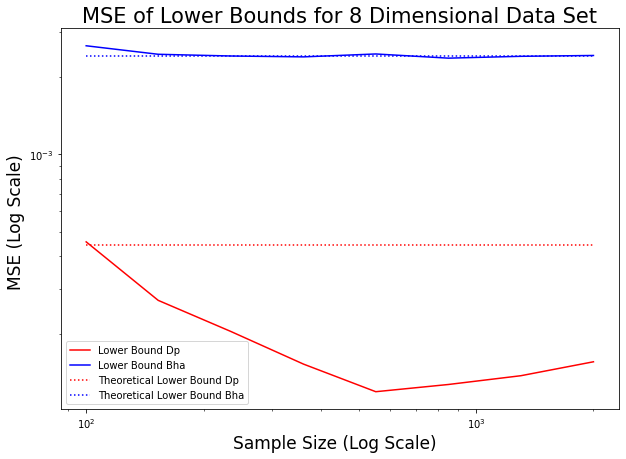

In [14]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, lower_mse_DP,'r', label='Lower Bound Dp')
ax.plot(sample_sizes, lower_mse_Bha,'b', label='Lower Bound Bha')

ax.plot(sample_sizes, dp_theoretical_l,  'r:', label='Theoretical Lower Bound Dp')

ax.plot(sample_sizes, bha_theoretical_l,  'b:', label='Theoretical Lower Bound Bha')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MSE (Log Scale) ", fontsize=fs)
ax.set_title("MSE of Lower Bounds for 8 Dimensional Data Set", fontsize = fs +4)
ax.legend()
# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)
plt.show()


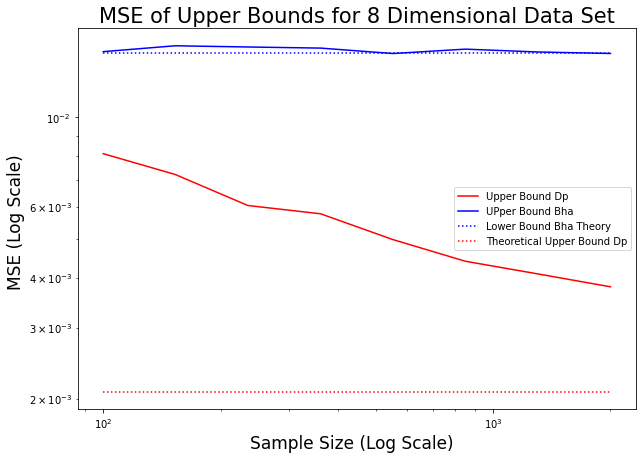

In [15]:
fs =17
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.set_xscale('log', base=10)
ax.set_yscale('log', base=10)

ax.plot(sample_sizes, upper_mse_DP, 'r', label='Upper Bound Dp')
ax.plot(sample_sizes, upper_mse_Bha,'b', label='UPper Bound Bha')

ax.plot(sample_sizes, bha_theoretical_u,  'b:', label='Lower Bound Bha Theory')
ax.plot(sample_sizes, dp_theoretical_u,  'r:', label='Theoretical Upper Bound Dp')

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("MSE (Log Scale) ", fontsize=fs)
ax.set_title("MSE of Upper Bounds for 8 Dimensional Data Set", fontsize = fs +4)
ax.legend()
# plt.savefig("log_test.png",facecolor=(1,1,1,1))
# ax.set_xticks(sample_sizes)
plt.show()

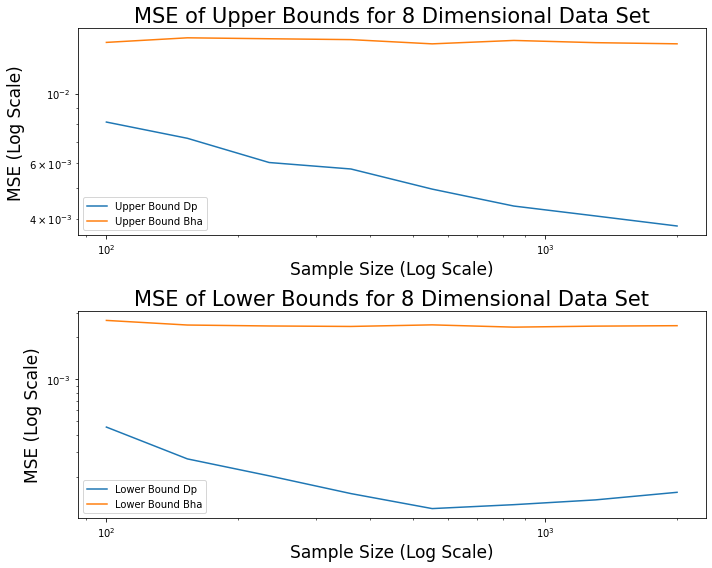

In [16]:
import matplotlib.pyplot as plt

fs = 17
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

# Plot for Upper Bounds
axes[0].set_xscale('log', base=10)
axes[0].set_yscale('log', base=10)
axes[0].plot(sample_sizes, upper_mse_DP, label='Upper Bound Dp')
axes[0].plot(sample_sizes, upper_mse_Bha, label='Upper Bound Bha')
axes[0].set_xlabel("Sample Size (Log Scale)", fontsize=fs)
axes[0].set_ylabel("MSE (Log Scale)", fontsize=fs)
axes[0].set_title("MSE of Upper Bounds for 8 Dimensional Data Set", fontsize=fs + 4)
axes[0].legend()

# Plot for Lower Bounds
axes[1].set_xscale('log', base=10)
axes[1].set_yscale('log', base=10)
axes[1].plot(sample_sizes, lower_mse_DP, label='Lower Bound Dp')
axes[1].plot(sample_sizes, lower_mse_Bha, label='Lower Bound Bha')
axes[1].set_xlabel("Sample Size (Log Scale)", fontsize=fs)
axes[1].set_ylabel("MSE (Log Scale)", fontsize=fs)
axes[1].set_title("MSE of Lower Bounds for 8 Dimensional Data Set", fontsize=fs + 4)
axes[1].legend()
plt.tight_layout()

# plt.savefig("Both_bounds.png",facecolor=(1,1,1,1))


plt.show()

In [17]:
validity_dp_l = np.zeros(len(sample_sizes))
validity_dp_u = np.zeros(len(sample_sizes))

validity_Bha_l = np.zeros(len(sample_sizes))
validity_Bha_u =  np.zeros(len(sample_sizes))

for i in range(len(sample_sizes)):
    Bha_l, Bha_u = Bha_lst[i].get_bounds()
    dp_l, dp_u = dp_lst[i].get_bounds()
    for j in range(MC_num):
        if Bha_l[j] < BER:
            validity_Bha_l[i] += 1
        if Bha_u[j] > BER:
            validity_Bha_u[i] += 1
    
        if dp_l[j] < BER:
            validity_dp_l[i] += 1
        if dp_u[j] > BER:
            validity_dp_u[i] += 1
    
        

In [18]:
print(validity_dp_l,  validity_dp_u, validity_Bha_l, validity_Bha_u )

[206. 215. 237. 259. 313. 362. 388. 400.] [399. 400. 400. 400. 400. 400. 400. 400.] [398. 400. 400. 400. 400. 400. 400. 400.] [400. 400. 400. 400. 400. 400. 400. 400.]


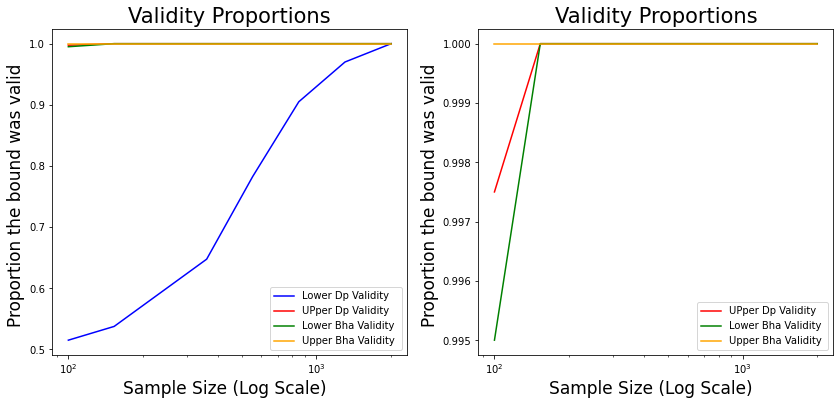

In [19]:
fs =17

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax = axes[0]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='UPper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')

# ax.set_xticks(sample_sizes)

ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


ax = axes[1]

ax.set_xscale('log', base=10)
# ax.set_yscale('log', base=10)

# ax.plot(sample_sizes, validity_dp_l/ MC_num, 'b',  label='Lower Dp Validity ')
ax.plot(sample_sizes, validity_dp_u/ MC_num, 'r', label='UPper Dp Validity ')

ax.plot(sample_sizes, validity_Bha_l/ MC_num,'g', label='Lower Bha Validity ')
ax.plot(sample_sizes, validity_Bha_u/ MC_num, 'orange', label='Upper Bha Validity ')


ax.set_xlabel("Sample Size (Log Scale)  ", fontsize = fs)
ax.set_ylabel("Proportion the bound was valid ", fontsize=fs)
ax.set_title("Validity Proportions" , fontsize = fs +4)
ax.legend()


# plt.savefig("proportions.png",facecolor=(1,1,1,1))
plt.show()